# Taller 2
Vihlai Maldonado Cuevas 201619479

## Objetivo
Evaluar las capacidades del estudiante para desarrollar modelos analíticos supervisados contemplando las etapas de la metodología ASUM-DM, como son el análisis y entendimiento de los datos, preparación de datos, creación de modelos, evaluación y análisis de resultados.

## Planteamiento del problema
La alcandía de una ciudad está interesada en implementar un nuevo servicio de patinetas para incentivar la movilidad sostenible y como parte de este proceso se encuentra evaluando la viabilidad económica e impacto de dicho servicio. Dado lo anterior, le ha encargado a la consultora Andes CDA el desarrollo de un modelo predictivo de la demanda de patinetas por día con base en datos de una ciudad vecina. Su objetivo como consultor de esta empresa es la creación del mejor modelo posible de regresión lineal que le permita predecir el número de usuarios promedio por día del nuevo servicio, al mismo tiempo de poder entender la importancia y relación de las variables consideradas. A continuación, se relaciona el diccionario de datos:

| Field      | Description                                                      |
|------------|------------------------------------------------------------------|
| Instant    | Record Index                                                     |
| Date       | Date (Format:YYYY-MM-DD)                                         |
| Season     | Season of the year                                               |
| Holiday    | Is it holiday?                                                   |
| Weather    | Description of the weather situation                             |
| Temp       | Temperature in Celsius                                           |
| Feel_Temp  | Feeling temperature in Celsius                                   |
| Hum        | Normalized humidity                                              |
| Wind       | Wind speed in m/s                                                |
| Casual     | Count of casual users                                            |
| Registered | Count of registered users                                        |
| cnt        | Count of total rental bikes including both casual and registered |

In [542]:
!pip install --upgrade pandas-profiling
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [543]:
# Importing libraries
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns
import csv
%matplotlib inline
import missingno as msno
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [544]:
# Pandas configuration for extending the number of rows and columns to visualize, if not limit set parameter to None or -1
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Lectura DataFrame
A continuación se hace la primera lectura del archivo CSV.

In [545]:
data_df = pd.read_csv('Data_Taller_2.csv', sep=';', decimal=",")
data_df.head()

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt
0,1,1/01/2020,Springer,No,Mist + Cloudy,8.175849,9.090375,0.805833,10.749882,331,654,985
1,2,2/01/2020,Springer,No,Mist + Cloudy,9.083466,8.625733,0.696087,-16.652113,131,670,801
2,3,3/01/2020,Springer,No,Few clouds,1.229108,0.902035,0.437273,16.636703,120,1229,1349
3,4,4/01/2020,Springer,No,Few clouds,1.400000,1.969734,0.590435,10.739832,108,1454,1562
4,5,5/01/2020,Springer,No,Partly cloudy,2.666979,2.775690,0.436957,12.522300,82,1518,1600


In [546]:
data_df['Date'][424]

'29/02/2021'

Como el año 2021 no es bisiesto, reemplazamos el día 29 de febrero por el día 28 de febrero:

In [547]:
data_df.at[424, 'Date'] = '28/02/2021'

Transformamos la columna a Date:

In [548]:
data_df['Date'] = pd.to_datetime(data_df['Date'],  format='%d/%m/%Y')

In [549]:
data_df['Date']

0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-05
         ...    
726   2021-12-27
727   2021-12-28
728   2021-12-29
729   2021-12-30
730   2021-12-31
Name: Date, Length: 731, dtype: datetime64[ns]

## Limpieza y preparación de datos
Búsqueda y corrección de valores atípicos, valores faltantes y duplicados; ya que el dataset no es muy extenso deberá abstenerse de eliminar registros. Así mismo, genere nuevas variables con base en la información suministrada. 

In [550]:
data_df.shape

(731, 12)

In [551]:
data_df[data_df.duplicated(keep=False)].sort_values('instant')

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt


Se observa que el dataset no contiene registros duplicados.

In [552]:
data_df['Weather'].unique()

array(['Mist + Cloudy', 'Few clouds', ' Partly    cloudy', 'Clear',
       'Mist', 'Mist + Broken clouds', ' Partly cloudy',
       'Mist + Few clouds', 'Rain + Thunderstorm',
       'Light Rain + Scattered clouds', 'Snow'], dtype=object)

Se observa que la variable `Weather` tiene registros malformados de' Partly    cloudy' y ' Partly cloudy'. Se procede a dejar un sólo valor.

In [553]:
data_df['Weather'] = data_df['Weather'].replace({' Partly    cloudy': 'Partly cloudy', ' Partly cloudy': 'Partly cloudy'})

In [554]:
data_df['Weather'].unique()

array(['Mist + Cloudy', 'Few clouds', 'Partly cloudy', 'Clear', 'Mist',
       'Mist + Broken clouds', 'Mist + Few clouds', 'Rain + Thunderstorm',
       'Light Rain + Scattered clouds', 'Snow'], dtype=object)

Valores nulos

In [555]:
null_data_df = data_df[data_df.isnull().any(axis=1)]
null_data_df

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt
99,100,2020-04-10,Summer,No,Mist + Few clouds,NaN,12.056639,0.857500,9.833389,1188,1707,2895
229,230,2020-08-18,Fall,No,Partly cloudy,NaN,23.126126,0.654583,15.624936,639,3166,3805
562,563,2021-07-16,Fall,No,Clear,NaN,26.033875,0.645000,11.000529,1088,5742,6830
721,722,2021-12-22,Springer,No,Partly cloudy,NaN,3.097311,10.441250,27.292182,205,1544,1749


Observamos que 4 registros no contienen datos para la columna `Temp`. Dado que el conjunto de datos es reducido, imputaremos los valores. Para ello se analizará la relación de la variable Temp con otras variables:

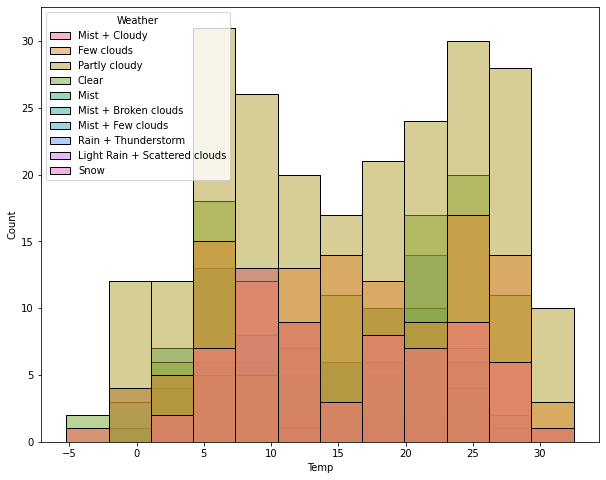

In [556]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=data_df, x= 'Temp', hue='Weather')

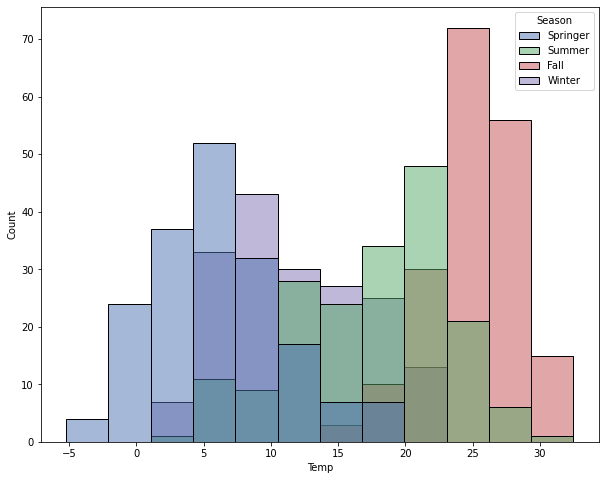

In [557]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=data_df, x= 'Temp', hue='Season')

[Text(0.5, 1.0, 'Temp vs Feel_Temp')]

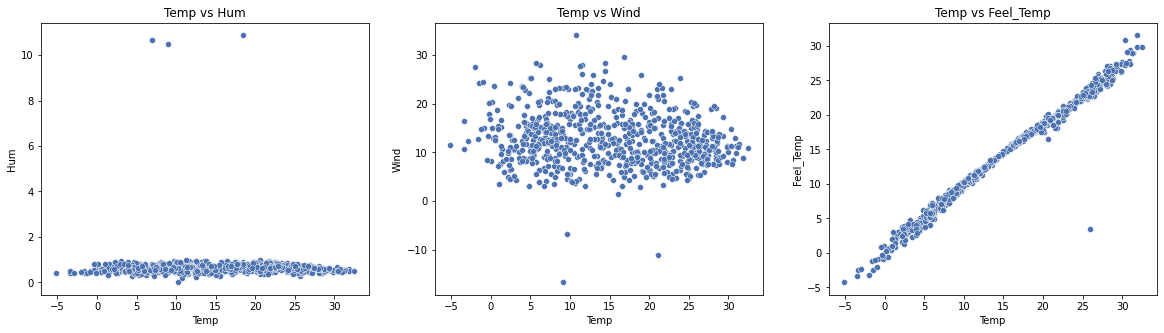

In [558]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.scatterplot(data=data_df, x= 'Temp', y='Hum', ax=axs[0]).set(Title='Temp vs Hum')
sns.scatterplot(data=data_df, x= 'Temp', y='Wind',ax=axs[1]).set(Title='Temp vs Wind')
sns.scatterplot(data=data_df, x= 'Temp', y='Feel_Temp',ax=axs[2]).set(Title='Temp vs Feel_Temp')

De acuerdo al resultado anterior vemos que la temperatura varía de acuerdo a los valores categóricos de la variable `Weather` y también de la variable `season`. La dependencia lineal con la variable `Hum` es baja y en menor medida de la variable `Wind`. Asimismo, observamos una fuerte correlación lineal con la variable `Feel_Temp`, razón por la cual usaremos esta variable para predecir los valores faltantes de la variable `Temp`. Para realizar esta imputación, se creará un modelo de regresión lineal simple entre la variable `Temp` y `Feel_Temp`, se entrenará con los valores no nulos y se predecirán los valores nulos:

In [559]:
#Modelo de regresión lineal
lin_reg_temp = LinearRegression()
lin_reg_temp.fit(data_df[~data_df.isnull().any(axis=1)]['Feel_Temp'].values.reshape(-1,1), data_df[~data_df.isnull().any(axis=1)]['Temp'].values.reshape(-1,1))
null_data_df['Feel_Temp']

99     12.056639
229    23.126126
562    26.033875
721     3.097311
Name: Feel_Temp, dtype: float64

In [560]:
#Predicción de los valores nulos
lin_reg_temp.predict(null_data_df['Feel_Temp'].values.reshape(-1,1))

array([[12.78791068],
       [25.12406661],
       [28.36454605],
       [ 2.80337688]])

In [561]:
#Asignación de la predicción a los valores nulos:
data_df.at[99, 'Temp'] = 12.78791068
data_df.at[229, 'Temp'] = 25.12406661
data_df.at[562, 'Temp'] = 26.033875
data_df.at[721, 'Temp'] = 3.097311

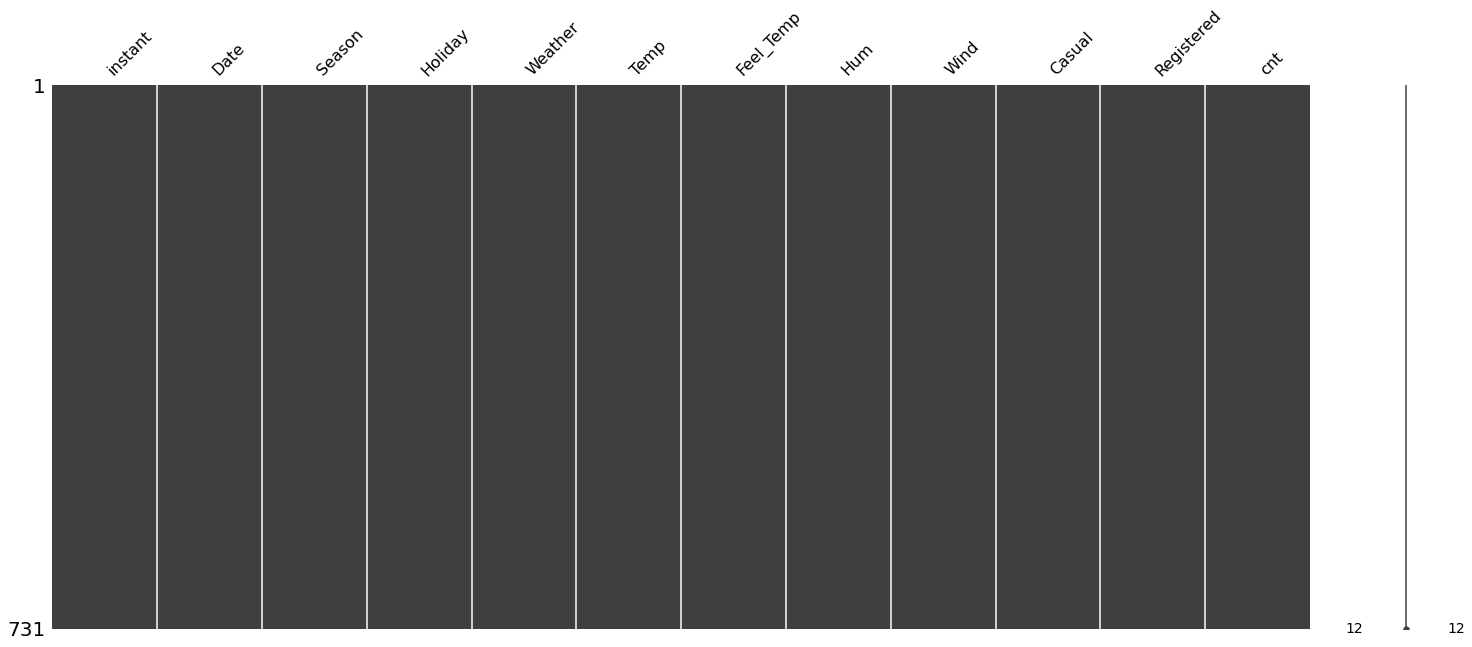

In [562]:
msno.matrix(data_df)

De esta manera no contamos con más valores nulos en el conjunto de datos.

Con respecto a los **valores atípicos**, estos se tratarán en la siguiente sección de **Análisis de datos**.

### Feature Engineering

La variable objetivo es `cnt`. Como el número de usuarios registrados y el de usuarios casuales no se conoce para datos nuevos, se creará una ventana de promedio móvil de 5 días, de tal manera que para un día en particular, asignaremos el promedio de los 5 días anteriores. Y para los primeros 5 días, asignaremos el valor dado por la varibale.

In [563]:
data_df['casual_avg'] = data_df['Casual'].rolling(window = 5).mean()
data_df.loc[data_df['casual_avg'].isnull(), 'casual_avg'] = data_df['Casual']

In [564]:
data_df['casual_avg']

0      331.0
1      131.0
2      120.0
3      108.0
4      154.4
       ...  
726    255.6
727    302.8
728    299.8
729    284.6
730    370.6
Name: casual_avg, Length: 731, dtype: float64

Asimismo, con la variable `Registered`, se creará una variable adicional con el promedio móvil de 5 días:

In [565]:
data_df['registered_avg'] = data_df['Registered'].rolling(window = 5).mean()
data_df.loc[data_df['registered_avg'].isnull(), 'registered_avg'] = data_df['Registered']

In [566]:
data_df['registered_avg']

0       654.0
1       670.0
2      1229.0
3      1454.0
4      1105.0
        ...  
726     999.4
727    1213.8
728    1301.0
729    1472.8
730    1844.4
Name: registered_avg, Length: 731, dtype: float64

Para hacer uso de la variable `Date` extraemos el día de la semana y el mes:

In [567]:
data_df['day_week'] = data_df['Date'].dt.dayofweek
data_df['month'] = data_df['Date'].dt.month

## Análisis de datos 
Analice las variables del dataset, entienda sus distribuciones y correlaciones, utilice ayudas visuales. 

In [568]:
data_df.columns

Index(['instant', 'Date', 'Season', 'Holiday', 'Weather', 'Temp', 'Feel_Temp',
       'Hum', 'Wind', 'Casual', 'Registered', 'cnt', 'casual_avg',
       'registered_avg', 'day_week', 'month'],
      dtype='object')

Variables **Categóricas**:
* Variables nominales:
  * Season
  * Weather
  * Holiday
* Variables ordinales:
  * Date

Variables **Cuantitativas**:
* Variables continuas:
  * Temp
  * Feel Temp
  * Hum
  * Wind
  * Casual
  * Registered
  * cnt
* Variables discretas:

### Variable `Season`

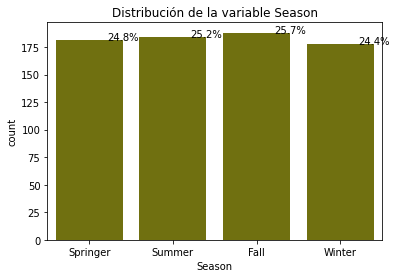

In [569]:
ax = sns.countplot(data=data_df, x='Season', color="olive")
ax.set(title = 'Distribución de la variable Season')
total = float(len(data_df['Season']))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Esta variable toma 4 categorías (Springer, Summer, Fall, Winter), distribuídas de manera casi equitativa.

### Variable `Holiday`

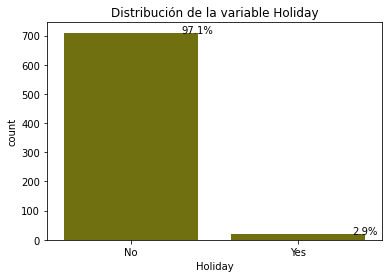

In [570]:
ax = sns.countplot(data=data_df, x='Holiday', color="olive")
ax.set(title = 'Distribución de la variable Holiday')
total = float(len(data_df['Holiday']))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Variable *booleana* donde el valor del No es el 97.1%.

### Variable `Weather`

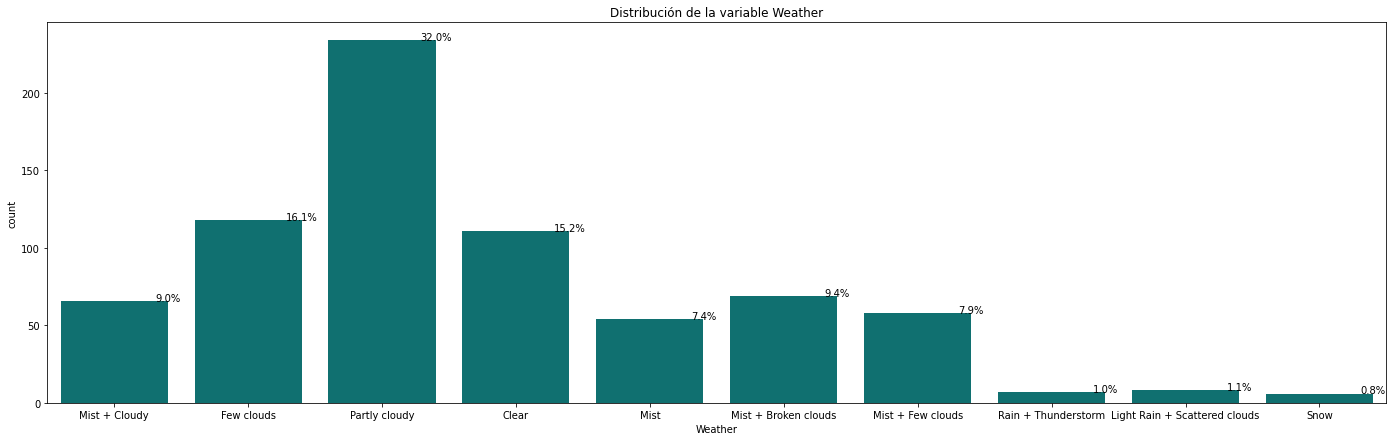

In [571]:
fig, ax = plt.subplots(figsize=(24, 7))
ax = sns.countplot(data=data_df, x='Weather', color="teal")
ax.set(title = 'Distribución de la variable Weather')
total = float(len(data_df['Weather']))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Esta variable toma 10 categorías distintas de clima, así como algunos tienen más de un clima asociado. La categoría que tiene más registros es 'Partly cloudy' con el 32%.

### Variable `Temp`

[Text(0.5, 1.0, 'Box Plot de Temp')]

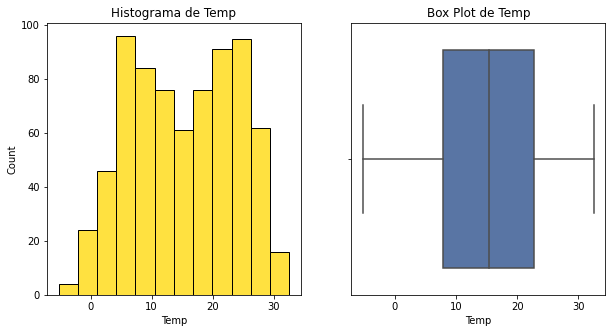

In [572]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data_df['Temp'], color="gold", ax=axs[0]).set(title='Histograma de Temp')
sns.boxplot(data=data_df, x='Temp', ax=axs[1]).set(title='Box Plot de Temp')

In [573]:
data_df['Temp'].describe()

count    731.000000
mean      15.279215
std        8.601675
min       -5.220871
25%        7.842925
50%       15.421651
75%       22.804575
max       32.498349
Name: Temp, dtype: float64

La variable se distribuye entre -5.22 y 32.49 °C. La media de la distribución está en 15.27 y la distribción luce bimodal, su primera moda cercana a 5 °C y la segunda moda a 25°C. Asimismo de acuerdo al diagrama de cajas no se observan valores atípicos.

### Variable `Feel_Temp`

[Text(0.5, 1.0, 'Box Plot de Temp')]

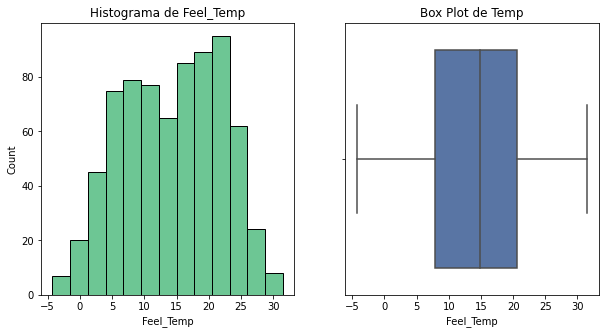

In [574]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data_df['Feel_Temp'], color="mediumseagreen", ax=axs[0]).set(title='Histograma de Feel_Temp')
sns.boxplot(data=data_df, x='Feel_Temp', ax=axs[1]).set(title='Box Plot de Temp')

In [575]:
data_df['Feel_Temp'].describe()

count    731.000000
mean      14.294637
std        7.659175
min       -4.283729
25%        7.878597
50%       14.876451
75%       20.604294
max       31.522112
Name: Feel_Temp, dtype: float64

La variable se distribuye entre -4.28 y 31.52°C. La media está alrededor de 14.29°C y de acuerdo al diagrama de cajas nos e observan valores atípicos.

### Variable `Hum`

[Text(0.5, 1.0, 'Box Plot de Hum')]

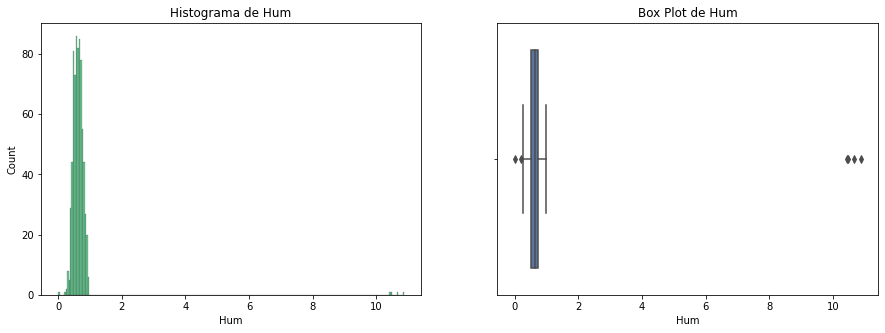

In [576]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_df['Hum'], color="mediumseagreen", ax=axs[0]).set(title='Histograma de Hum')
sns.boxplot(data=data_df, x='Hum', ax=axs[1]).set(title='Box Plot de Hum')

In [577]:
data_df['Hum'].describe()

count    731.000000
mean       0.682614
std        0.750679
min        0.000000
25%        0.522291
50%        0.629167
75%        0.732708
max       10.867083
Name: Hum, dtype: float64

La variable se distribuye entre 0 y 10.86. La media de la distribución es de 0.68 y de acuerdo al diagrama de cajas tiene valores atípicos más grandes que 10.\
Con respecto a los valores atípicos se aplicará una transformación para evitar remover estos datos, se utilizará [clipping](https://developers.google.com/machine-learning/data-prep/transform/normalization), y se fijará el valor máximo a ser el percentil 99 y el mínimo al percentil 1, también conocido como [winsorizing](https://en.wikipedia.org/wiki/Winsorizing). Es decir si un dato es mayor al percentil 0.99 se le imputará el percentil 0.99 y lo mismo para datos por debajo del percentil 1.

In [578]:
first_percent_hum = data_df['Hum'].quantile(0.01)
ninety_nine_percent_hum = data_df['Hum'].quantile(0.99)
data_df.loc[data_df['Hum'] <first_percent_hum, 'Hum'] = first_percent_hum
data_df.loc[data_df['Hum'] >ninety_nine_percent_hum, 'Hum'] = ninety_nine_percent_hum

Box plot con la variable transformada:

[Text(0.5, 1.0, 'Box Plot de Hum')]

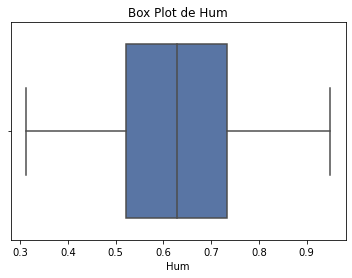

In [579]:
sns.boxplot(data=data_df, x='Hum').set(title='Box Plot de Hum')

### Variable `Wind`

[Text(0.5, 1.0, 'Box Plot de Wind')]

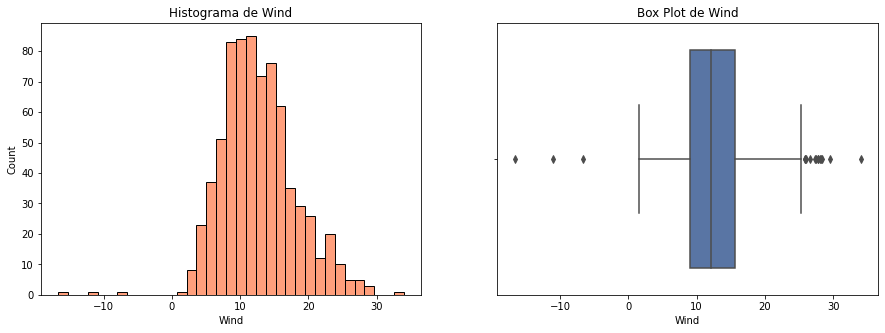

In [580]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_df['Wind'], color="coral", ax=axs[0]).set(title='Histograma de Wind')
sns.boxplot(data=data_df, x='Wind', ax=axs[1]).set(title='Box Plot de Wind')

In [581]:
data_df['Wind'].describe()

count    731.000000
mean      12.668792
std        5.417463
min      -16.652113
25%        9.000746
50%       12.124789
75%       15.624802
max       34.000021
Name: Wind, dtype: float64

La variable se distribuye entre -16.65 y 34. La media es de 12.66. De acuerdo al diagrama de cajas tenemos valores atípicos por debajo de 0 y por encima de 25. Con respecto a estos valores atípicos se procederá a imputarlos con respecto al percentil 1 y 99, similar a la variable anterior:

In [582]:
first_percent_wind= data_df['Wind'].quantile(0.01)
ninety_nine_percent_wind = data_df['Wind'].quantile(0.99)
data_df.loc[data_df['Wind'] <first_percent_wind, 'Wind'] = first_percent_wind
data_df.loc[data_df['Wind'] >ninety_nine_percent_wind, 'Wind'] = ninety_nine_percent_wind

In [583]:
first_percent_wind

3.1381125

Box plot con la variable transformada:

[Text(0.5, 1.0, 'Box Plot de Wind')]

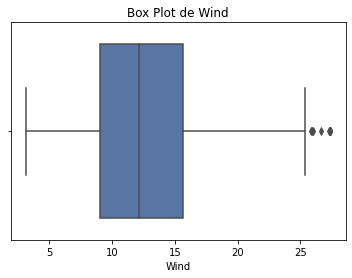

In [584]:
sns.boxplot(data=data_df, x='Wind').set(title='Box Plot de Wind')

### Variable `Casual`

[Text(0.5, 1.0, 'Box Plot de Casual')]

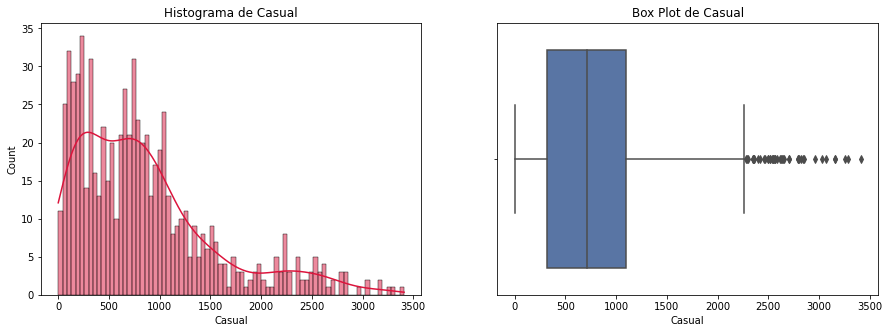

In [585]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_df['Casual'], kde=True, bins=80, color="crimson", ax=axs[0]).set(title='Histograma de Casual')
sns.boxplot(data=data_df, x='Casual', ax=axs[1]).set(title='Box Plot de Casual')

In [586]:
data_df['Casual'].describe()

count     731.000000
mean      848.176471
std       686.622488
min         2.000000
25%       315.500000
50%       713.000000
75%      1096.000000
max      3410.000000
Name: Casual, dtype: float64

La variable se distribuye entre 2 y 3410. La media se ubica alrededor de 848.17. De acuerdo al diagrama de cajas, tenemos valores atípicos por encima de 2200. Con respecto a los valores atípicos se aplicará winsorizing con los percentiles 5 y 95 ya que observamos bastantes valores extremos muy cercanos al whisker superior.

In [587]:
ninety_fifth_percent_casual = data_df['Casual'].quantile(0.95)
data_df.loc[data_df['Casual'] >ninety_fifth_percent_casual, 'Casual'] = ninety_fifth_percent_casual

Box plot con la variable transformada:

[Text(0.5, 1.0, 'Box Plot de Casual')]

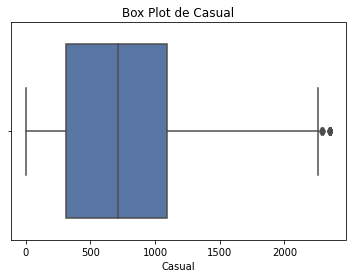

In [588]:
sns.boxplot(data=data_df, x='Casual').set(title='Box Plot de Casual')

### Variable `Registered`

[Text(0.5, 1.0, 'Box Plot de Registered')]

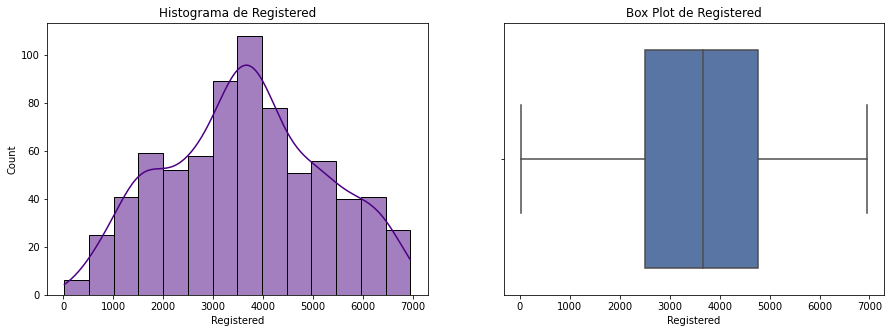

In [589]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_df['Registered'], kde=True, color="indigo", ax=axs[0]).set(title='Histograma de Registered')
sns.boxplot(data=data_df, x='Registered', ax=axs[1]).set(title='Box Plot de Registered')

In [590]:
data_df['Registered'].describe()

count     731.000000
mean     3656.172367
std      1560.256377
min        20.000000
25%      2497.000000
50%      3662.000000
75%      4776.500000
max      6946.000000
Name: Registered, dtype: float64

La variable se distribuye entre 20 y 6946, la distribución luce simétrica. La media de la distribución se ubica alrededor de 3656.17. De acuerdo al diagrama de cajas no tenemos valores atípicos.

### Variable `Cnt`

[Text(0.5, 1.0, 'Box Plot de cnt')]

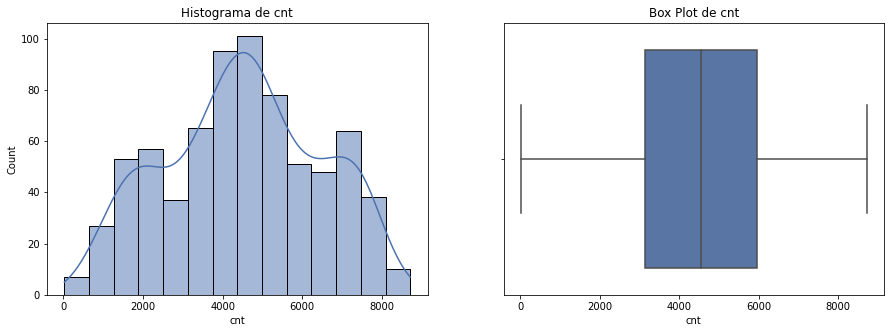

In [591]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data_df['cnt'], kde=True, ax=axs[0]).set(title='Histograma de cnt')
sns.boxplot(data=data_df, x='cnt', ax=axs[1]).set(title='Box Plot de cnt')

In [592]:
data_df['cnt'].describe()

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64

La variable se distribuye entre 22 y 8714, la distribución luce simétrica. La media se ubica alrededor de 4504.34. De acuerdo al diagrama de cajas no tenemos valores atípicos.

### Correlaciones y bivariados

In [593]:
correlation_df = data_df[['Temp', 'Feel_Temp', 'Hum', 'Wind', 'casual_avg', 'registered_avg', 'cnt', 'day_week', 'month']].corr()
correlation_df

,Temp,Feel_Temp,Hum,Wind,casual_avg,registered_avg,cnt,day_week,month
Temp,1.000000,0.991682,0.112901,-0.156334,0.751146,0.572573,0.627505,-0.008190,0.219748
Feel_Temp,0.991682,1.000000,0.126046,-0.181539,0.750149,0.574233,0.631066,-0.003303,0.227459
Hum,0.112901,0.126046,1.000000,-0.229372,0.049756,0.013024,-0.114786,0.015526,0.224771
Wind,-0.156334,-0.181539,-0.229372,1.000000,-0.110759,-0.169121,-0.228386,-0.007988,-0.201684
casual_avg,0.751146,0.750149,0.049756,-0.110759,1.000000,0.715105,0.729371,0.160534,0.185848
registered_avg,0.572573,0.574233,0.013024,-0.169121,0.715105,1.000000,0.894982,-0.067881,0.353867
cnt,0.627505,0.631066,-0.114786,-0.228386,0.729371,0.894982,1.000000,-0.016153,0.279977
day_week,-0.008190,-0.003303,0.015526,-0.007988,0.160534,-0.067881,-0.016153,1.000000,-0.008438
month,0.219748,0.227459,0.224771,-0.201684,0.185848,0.353867,0.279977,-0.008438,1.000000


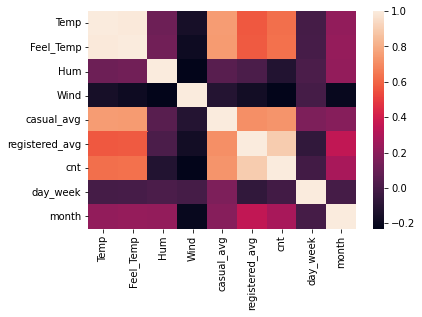

In [594]:
sns.heatmap(correlation_df)

Se observa una fuerte correlación entre las variables `Temp` y `Feel_Temp` con 0.99,  `registered_avg` y `cnt` de 0.89. Una correlación medianamente débil entre las variables `Temp` y `cnt` de 0.62, `Temp` y `casual_avg` de 0.75 y `Temp` y `registered_avg` de 0.57, lo mismo con `Feel_Temp`, así como `casual_avg` y `cnt` con 0.72.
Debido a la alta correlación entre las variables `Temp` y `Feel_Temp` decidimos tener en cuenta sólo una para el entrenamiento de los modelos, por simplicidad se escogerá `Temp`. \
En general, con respecto a la variable objetivo, observamos que `registered_avg`y `casual_avg` tienen una alta correlación, por lo que se espera que sean variables importantes en el modelo de regresión lineal.

[Text(0.5, 1.0, 'Usuarios totales vs Season')]

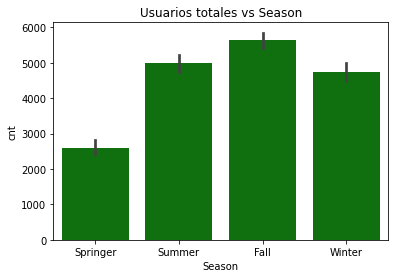

In [595]:
sns.barplot(data=data_df, x='Season', y='cnt', color='green').set(title='Usuarios totales vs Season')

La gráfica anterior muestra que hay mayor cantidad de usuarios para otoño y verano respectivamente.

[Text(0.5, 1.0, 'Usuarios totales vs Weather')]

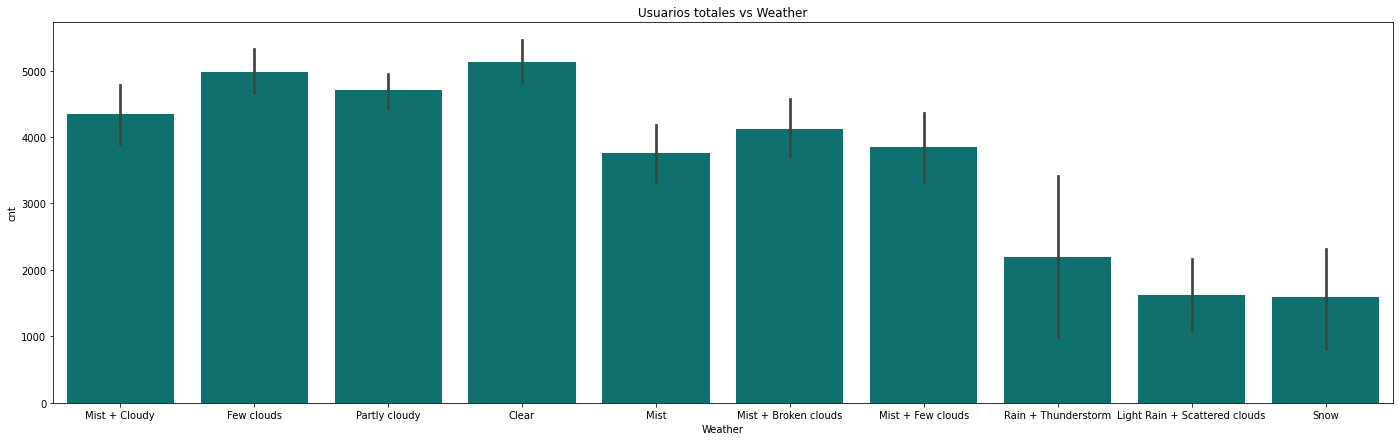

In [596]:
fig, ax = plt.subplots(figsize=(24, 7))
sns.barplot(data=data_df, x='Weather', y='cnt', color='teal').set(title='Usuarios totales vs Weather')

La gráfica anterior muestra que tenemos más cantidad de usuarios con un clima despejado (*Clear*) y de pocas nubes (*few clouds*).

[Text(0.5, 1.0, 'Usuarios totales vs day of week')]

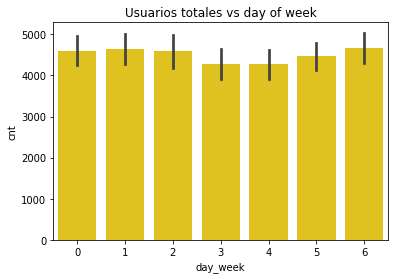

In [597]:
sns.barplot(data=data_df, x='day_week', y='cnt', color='gold').set(title='Usuarios totales vs day of week')

De acuerdo a la gráfica anterior, observamos que los días con menor cantidad de usuarios son jueves y viernes y los días con mayor cantidad de usuarios son domingo, lunes, martes y miércoles.

## Desarrollo de modelos de Machine Learning
Implemente al menos 3 modelos basados en el algoritmo de regresión lineal: uno simple, uno polinomial y uno con algún tipo de regularización.

In [598]:
processed_df = data_df.copy()

Preprocesamiento: \
### Variable `Season`
Como la variable es categórica nominal, aplicaremos one-hot encoding

In [599]:
season_dummies = pd.get_dummies(processed_df['Season'], prefix='season_')
processed_df = pd.concat([processed_df, season_dummies], axis = 1).drop('Season', axis=1)

### Variable Holiday 
Como la variable es booleana, se reemplazaran estos valores por 0, 1.

In [600]:
processed_df['Holiday'].unique()

array(['No', 'Yes'], dtype=object)

In [601]:
processed_df['Holiday'] = processed_df['Holiday'].replace({'Yes': 1, 'No': 0})

### Variable Weather
Como esta variable es categórica nominal aplicaremos one-hot encoding:

In [602]:
weather_dummies = pd.get_dummies(processed_df['Weather'], prefix='weather_')
processed_df = pd.concat([processed_df, weather_dummies], axis = 1).drop('Weather', axis=1)

In [603]:
X=processed_df.drop(['instant', 'Date', 'Registered', 'cnt', 'Feel_Temp', 'Casual'], axis=1)
Y=processed_df['cnt']

In [604]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [605]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [606]:
#Modelo de regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression()

In [607]:
preds_train = lin_reg.predict(X_train)
preds_test = lin_reg.predict(X_test)
r2_score(Y_test, preds_test)

0.8771715019598816

In [608]:
print('MAE (train, test): ', mean_absolute_error(Y_train, preds_train), mean_absolute_error(Y_test, preds_test))
print('RMSE (train, test): ', np.sqrt(mean_squared_error(Y_train, preds_train)), np.sqrt(mean_squared_error(Y_test, preds_test)))
print('MSE (train, test): ', mean_squared_error(Y_train, preds_train), mean_squared_error(Y_test, preds_test))
print('r2 en entrenamiento : ', r2_score(Y_train, preds_train))
print('r2 en test : ', r2_score(Y_test, preds_test))

MAE (train, test):  513.9782858578367 498.5740492967882
RMSE (train, test):  680.5509067071056 673.7358332050411
MSE (train, test):  463149.5366198635 453919.9729444909
r2 en entrenamiento :  0.8754847142036548
r2 en test :  0.8771715019598816


In [609]:
#Modelo regresión polinomial 2 grado
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly_features.fit_transform(X_train)
x_test_poly = poly_features.fit_transform(X_test)
lg = LinearRegression()
lg.fit(x_train_poly, Y_train)
preds_train_poly = lg.predict(x_train_poly)
preds_test_poly = lg.predict(x_test_poly)

In [619]:
print('MAE (train, test): ', mean_absolute_error(Y_train, preds_train_poly), mean_absolute_error(Y_test, preds_test_poly))
print('RMSE (train, test): ', np.sqrt(mean_squared_error(Y_train, preds_train_poly)), np.sqrt(mean_squared_error(Y_test, preds_test_poly)))
print('MSE (train, test): ', mean_squared_error(Y_train, preds_train_poly), mean_squared_error(Y_test, preds_test_poly))
print('r2 en entrenamiento : ', r2_score(Y_train, preds_train_poly))
print('r2 en test : ', r2_score(Y_test, preds_test_poly))

MAE (train, test):  355.7930958369007 23732644026756.145
RMSE (train, test):  475.65168980228054 158691551239746.9
MSE (train, test):  226244.53001176493 2.5183008434877214e+28
r2 en entrenamiento :  0.9391753632749581
r2 en test :  -6.814397441299335e+21


De acuerdo al resultado anterior observamos overfitting, ya que el error en test es bastante alto. A continuación usaremos regularización:

In [611]:
for model_degree in [2, 3, 4, 5, 6]:
  print("Modelo de regresión polinomial grado: ", model_degree)
  poly_features = PolynomialFeatures(degree=model_degree, include_bias=False)
  for alpha in [0.1, 1, 10, 100, 1000, 2000, 5000]:
    x_train_poly = poly_features.fit_transform(X_train)
    x_test_poly = poly_features.fit_transform(X_test)
    ridge_reg = Ridge(alpha=alpha, solver='cholesky')
    ridge_reg.fit(x_train_poly, Y_train)
    ridge_preds_train = ridge_reg.predict(x_train_poly)
    ridge_preds_test = ridge_reg.predict(x_test_poly)
    print("Desempeño en datos de test, alpha = ", alpha)
    print('MAE: ', mean_absolute_error(Y_test, ridge_preds_test))
    print('MSE: ', mean_squared_error(Y_test, ridge_preds_test))
    print('r2 en test : ', r2_score(Y_test, ridge_preds_test))

Modelo de regresión polinomial grado:  2
Desempeño en datos de test, alpha =  0.1
MAE:  602.864233742649
MSE:  1255695.2586883632
r2 en test :  0.6602150779568123
Desempeño en datos de test, alpha =  1
MAE:  584.4055395428952
MSE:  1020921.5737990505
r2 en test :  0.7237436750952881
Desempeño en datos de test, alpha =  10
MAE:  523.8338689457623
MSE:  535914.7267966972
r2 en test :  0.8549841273936002
Desempeño en datos de test, alpha =  100
MAE:  527.2419186774589
MSE:  494055.0907587356
r2 en test :  0.8663111377247309
Desempeño en datos de test, alpha =  1000
MAE:  852.1960136580941
MSE:  1058465.9452528711
r2 en test :  0.7135843540025875
Desempeño en datos de test, alpha =  2000
MAE:  980.9133937836864
MSE:  1388928.7847378247
r2 en test :  0.6241627452359397
Desempeño en datos de test, alpha =  5000
MAE:  1151.2337576063971
MSE:  1905662.567434889
r2 en test :  0.48433714116843374
Modelo de regresión polinomial grado:  3
Desempeño en datos de test, alpha =  0.1
MAE:  1834.9377258

De acuerdo al resultado anterior observamos que a un mayor grado del polinomio el error en los datos de test es más alto, lo cual implica que el modelo se está sobreajustando a los datos de entrenamiento. Asimismo conforme aumentan los valores de $\alpha$ (y menores a 2000) en la regularización *Ridge*, observamos que para polinomios de alto grado, las métricas de error disminuyen considerablemente, lo cual indica que la regularización ayuda con el problema de sobreajuste

## Evaluación de modelos
Con base en el desempeño de cada uno de los modelos anteriormente desarrollados, concluya cual es el modelo que se le debe presentar al cliente y exponga sus razones.

De acuerdo a los resultados dados en el punto anterior, observamos que con un polinomio de segundo grado y $\alpha$ con valor de 100, obtenemos un MAE de 527.24 y $r^2$ de 0.866 el cual es el mejor modelo de regresión polinomial y con respecto a regresión lineal obtenemos un MAE de 498.57 y $r^2$ de 0.87 para datos de test, lo cual muestra que es el mejor modelo obtenido. Dadas las métricas de error y teniendo en cuenta que el modelo de regresión lineal es menos complejo, se escogerá este modelo para presentar al cliente. Asimismo, con respecto a las variables nuevas añadidas de casual_avg y registered_avg

## Interpretación 
El día de la presentación del modelo ante el cliente una persona de la alcaldía le hace las siguientes preguntas: 
* ¿Cuáles son las 3 variables más importantes para la predicción de la cantidad de usuarios?
* Describa cual es el escenario ideal para el incremento de usuarios
* ¿Qué pasos adicionales deberían tener en cuenta para una próxima iteración/mejora del modelo? 

Ayuda
*	Al consultar a un meteorólogo el cual nos sugiere agrupar las precipitaciones en un grupo, la neblina en otro grupo y el resto en otro. 
* Es de interés particular el comportamiento de los usuarios durante la semana.
* Realice imputación y corrección de variables según el sentido común y la lógica del dataset.


In [612]:
coeff_df = pd.DataFrame()
coeff_df['features'] = X.columns
coeff_df['coef'] = lin_reg.coef_
coeff_df.sort_values(by='coef', key=abs, ascending=False)

,features,coef
5,registered_avg,1407.765444
1,Temp,215.204108
4,casual_avg,181.320789
3,Wind,-176.985942
20,weather__Rain + Thunderstorm,-146.197051
2,Hum,-145.281848
21,weather__Snow,-142.860189
16,weather__Mist + Broken clouds,-131.349129
14,weather__Light Rain + Scattered clouds,-125.806818
13,weather__Few clouds,113.066937


In [613]:
lin_reg.intercept_

4595.313356164384

De acuerdo a lo anterior observamos que las tres variables más importantes para la predicción de la cantidad de usuarios de acuerdo a los pesos de los coeficientes son:
* `registered_avg` con un peso de 1407.7, esta es una variable adicional que se calculó con el promedio móvil de los 5 días anteriores.
* `Temp`  con un peso de 215.20.
* `casual_avg` con un peso de 181.32, al igual que la primera variable, se calculó con el promedio móvil de los 5 días anteriores.

Describa cual es el escenario ideal para el incremento de usuarios

In [614]:
data_df['Weather'].unique()

array(['Mist + Cloudy', 'Few clouds', 'Partly cloudy', 'Clear', 'Mist',
       'Mist + Broken clouds', 'Mist + Few clouds', 'Rain + Thunderstorm',
       'Light Rain + Scattered clouds', 'Snow'], dtype=object)

In [615]:
data_df['weather_group'] = np.where(data_df['Weather'].isin(['Rain + Thunderstorm', 'Light Rain + Scattered clouds', 'Snow']), 'precipitaciones', '')
data_df['weather_group'] = np.where(data_df['Weather'].isin(['Mist + Cloudy', 'Mist', 'Mist + Broken clouds', 'Mist + Few clouds']), 'neblina', data_df['weather_group'])
data_df.loc[data_df['weather_group'] == '', 'weather_group'] = 'general'

In [616]:
data_df['weather_group'].unique()

array(['neblina', 'general', 'precipitaciones'], dtype=object)

[Text(0.5, 1.0, 'Usuarios totales vs Weather')]

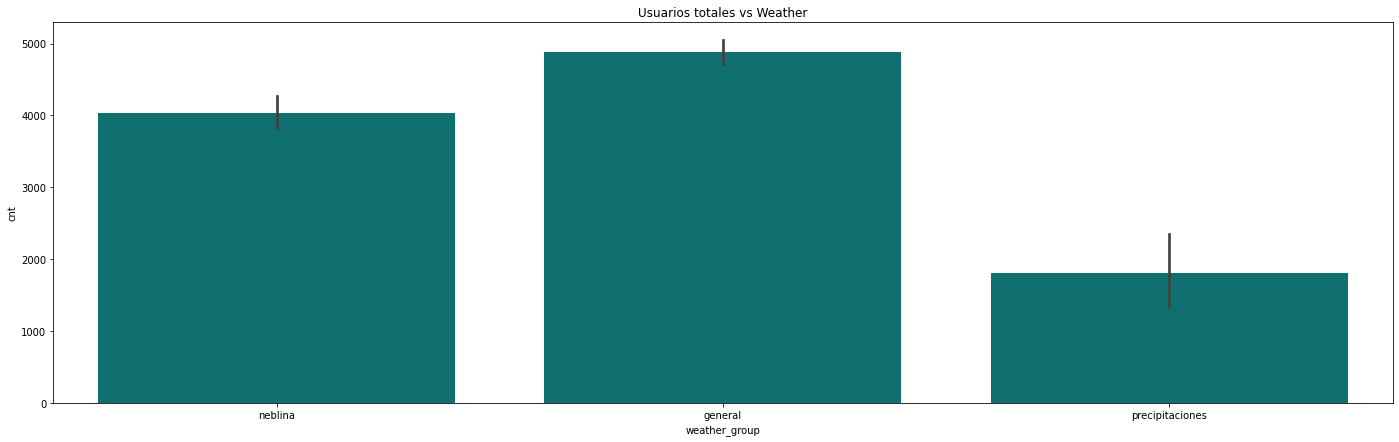

In [617]:
fig, ax = plt.subplots(figsize=(24, 7))
sns.barplot(data=data_df, x='weather_group', y='cnt', color='teal').set(title='Usuarios totales vs Weather')

De acuerdo a la gráfica anterior, el escenario ideal donde tenemos gran afluencia de usuarios es cuando no tenemos precipitaciones, el grupo general agrupa clima despejado y parcialmente nublado donde tenemos la mayor afluencia de usuarios. Asimismo, cuando hay presencia de neblina la afluencia es menor pero está alrededor de los 4000 en total y cuando tenemos precipitaciones tenemos la menor afluencia de usuarios, al rededor de 2000 en total.

[Text(0.5, 1.0, 'Usuarios totales vs day of week')]

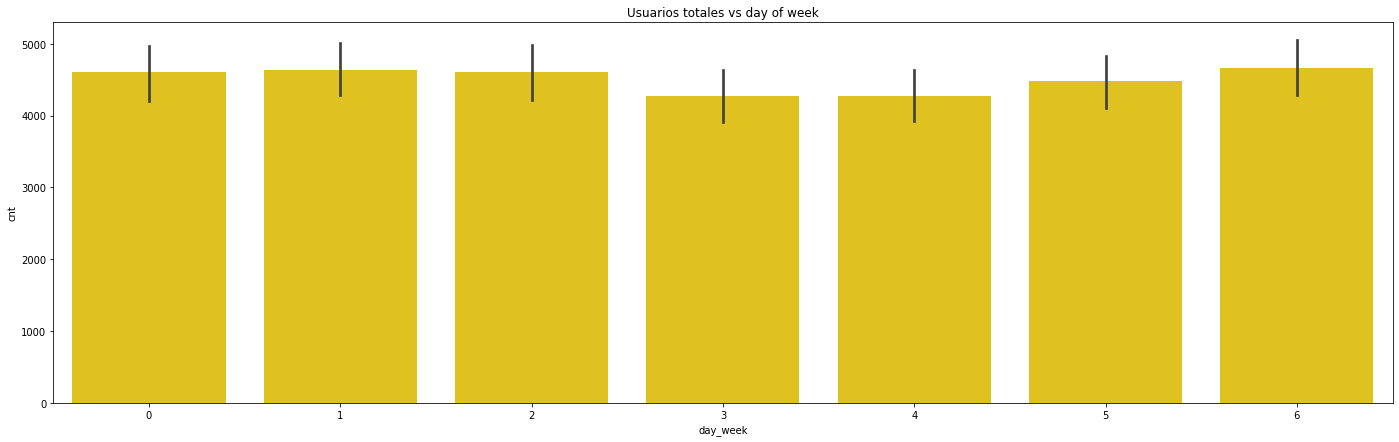

In [618]:
fig, ax = plt.subplots(figsize=(24, 7))
sns.barplot(data=data_df, x='day_week', y='cnt', color='gold').set(title='Usuarios totales vs day of week')

Asimismo, en cuanto a dias de la semana, tenemos mayor afluencia los lunes, martes, miércoles y domingo.

¿Qué pasos adicionales deberían tener en cuenta para una próxima iteración/mejora del modelo? 

Como sugerencia para una próxima iteración, se recomienda recolectar datos del tiempo al que es tomado el dato, por ejemplo la hora, de tal manera que podamos analizar las horas en las que tenemos más usuarios. Esto nos permitiría mejorar temas de logística y predecir temas de picos de demanda de patinetas y cantidad de patinetas que deberían estar disponibles para suplir esta demanda. Asimismo, se propone continuar registrando el número de usuarios casuales y registrados cada día, ya que como vimos, al usar el promedio móvil de 5 días son de las variables más importantes en el modelo. En cuanto al modelo se propone explorar nuevas técnicas de regresión y modelos no lineales, por ejemplo una red neuronal.